In [51]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse as ph
import hashlib
import swifter
from scipy import stats

In [52]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20240120',
'user':'student',
'password':'dpo_python_2020'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-12-29' and '2024-01-04'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

In [53]:
print(df)

       exp_group  user_id  likes  views       ctr
0              1   109963      3     15  0.200000
1              1    26117     32    141  0.226950
2              1   138232     18     73  0.246575
3              1    18392      7     32  0.218750
4              1    26295     39    141  0.276596
...          ...      ...    ...    ...       ...
19892          2    17146      0     10  0.000000
19893          1    30872     11     59  0.186441
19894          2    25383     42    127  0.330709
19895          2   139020     17     41  0.414634
19896          2    17310      9     82  0.109756

[19897 rows x 5 columns]


# Сформулирую гипотезу:
## Н0 - CTR в двух группах одинаковые
## Н1 - CTR в двух группах не равны

## группа 1 - контрольная группа
## группа 2 - тестовая группа

## Проверяю равенство записей в группах 1 и 2

In [54]:
#в абсолютном количестве
df.groupby('exp_group')['user_id'].nunique()

exp_group
1    10020
2     9877
Name: user_id, dtype: int64

In [55]:
#в процентах
share_1 = (df[df['exp_group'] == 1]['user_id'].count() / df['user_id'].count()) * 100
share_2 = (df[df['exp_group'] == 2]['user_id'].count() / df['user_id'].count()) * 100
print(share_1)
print(share_2)

50.35935065587777
49.64064934412223


Количество пользователей в группах почти одинаковое

## Визуализирую распределения групп

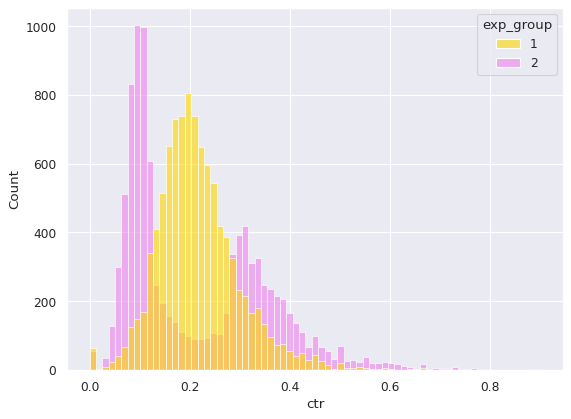

In [17]:
sns.set(rc={'figure.figsize':(8, 6), 'figure.dpi': 80})
g = sns.histplot(data = df, x = 'ctr', hue = 'exp_group', palette = ['gold','violet'], alpha = 0.6, kde = False)

Распределение 1ой группы похоже на нормальное, а распределение 2ой группы - двугорбое

## T-test

In [18]:
stats.ttest_ind(df[df['exp_group'] == 1].ctr, df[df['exp_group'] == 2].ctr, equal_var = False )

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

p-value равен 0.68, что не позволяет отклонить нулевую гипотезу

## тест Манна_Уитни

In [19]:
stats.mannwhitneyu(df[df['exp_group'] == 1].ctr, df[df['exp_group'] == 2].ctr, alternative = 'two-sided' )

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

In [20]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 55.91 % случаев A > B. Должно получиться около 50%


Тест Манна-Уитни видит различия в группах и позволяет отклонить нулевую гипотезу

## Я получил различия в двух тестах: результат t-теста не позволяет отклонить нулевую гипотезу, а тест Манна-Уитни - позволяет. Думаю, что t-test мог сработать неправильно,так как распределение CTR для 2 группы сильно отличается от нормального.

## Сглаженный CTR

In [57]:
#функция сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [58]:
#считаю общегрупповые CTR для 1 и 2 групп
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

## Визуализирую распределения CTR для двух групп ДО и ПОСЛЕ сглаживания CTR

<Axes: xlabel='ctr', ylabel='Count'>

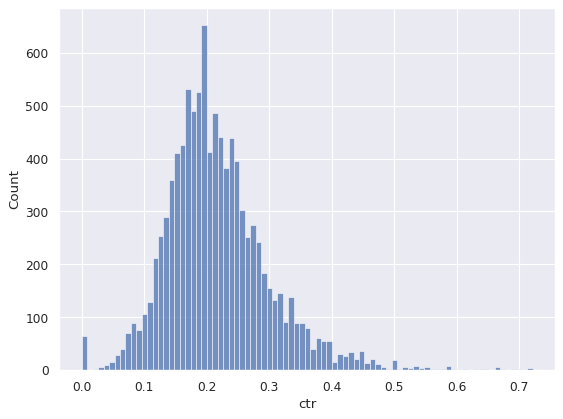

In [59]:
#1 группа до сглаживания
gr_1 = df[df.exp_group == 1].copy()
sns.histplot(gr_1.ctr, 
             kde = False, color = 'b')

<Axes: xlabel='smothed_CTR', ylabel='Count'>

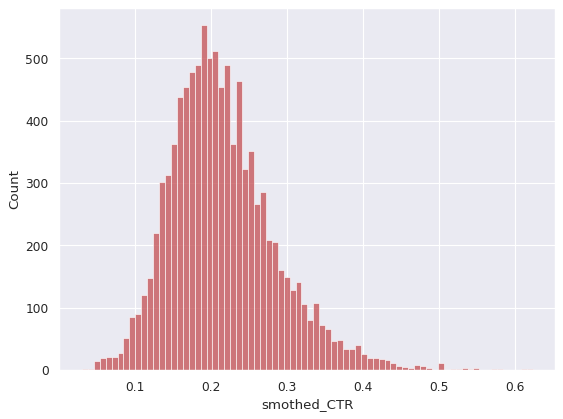

In [60]:
#1 группа после сглаживания
gr_1['smothed_CTR'] = df.apply(lambda x: get_smothed_ctr (x['likes'], x['views'], global_ctr_1, 5), axis = 1)

sns.histplot(gr_1.smothed_CTR, 
             kde = False, color = 'r')

<Axes: xlabel='ctr', ylabel='Count'>

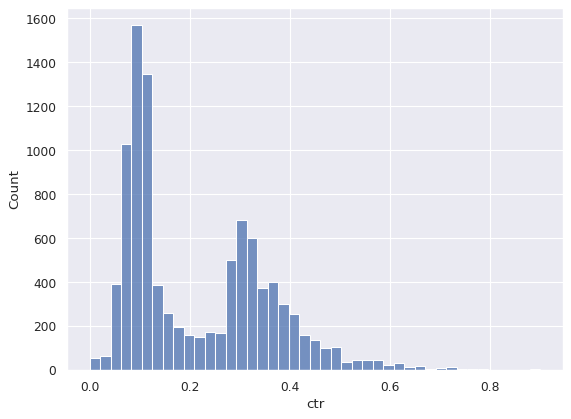

In [61]:
#2 группа до сглаживания
gr_2 = df[df.exp_group == 2].copy()
sns.histplot(gr_2.ctr, kde = False, color = 'b')

<Axes: xlabel='smothed_CTR', ylabel='Count'>

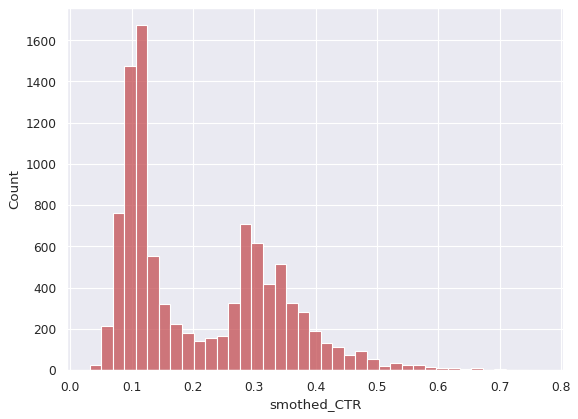

In [62]:
#2 группа после сглаживания
gr_2['smothed_CTR'] = df.apply(lambda x: get_smothed_ctr (x['likes'], x['views'], global_ctr_2, 5), axis = 1)

sns.histplot(gr_2.smothed_CTR, kde = False, color = 'r')

Для 1 группы сглаженный CTR сыграл положительно, избавив от "пиков" и приблизив распределение к нормальному.
ДЛя 2 группы сглаженный CTR не сыграл особой роли.

## Провожу тесты на сглаженном CTR

In [63]:
#t-test на сглаженном CTR

stats.ttest_ind(gr_1.smothed_CTR, gr_2.smothed_CTR, equal_var = False )

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

In [64]:
#тест Манна-Уитни

stats.mannwhitneyu(gr_1.smothed_CTR, gr_2.smothed_CTR, alternative = 'two-sided' )

MannwhitneyuResult(statistic=55528353.0, pvalue=2.396534039374286e-50)

In [65]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= gr_1.smothed_CTR.sample().values[0] > gr_2.smothed_CTR.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 56.13 % случаев A > B. Должно получиться около 50%


## T-test показал значение p-value = 0.0516, что все еще немного более 0.05, что не позволяет отклонить нулевую гипотезу, но при этом это значительно меньше p-value в t-тесте без сглаживания CTR. Тест Манна-Уитни показал различия в группах, p-value даже меньше, чем в тесте без сглаживания.

## Пуассновский бутстреп

In [66]:
#Функция для Пуассоновского бутстрепа
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [67]:
#преобразую в массивы numpy
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

## Визуализирую распределения глобальных CTR по группам

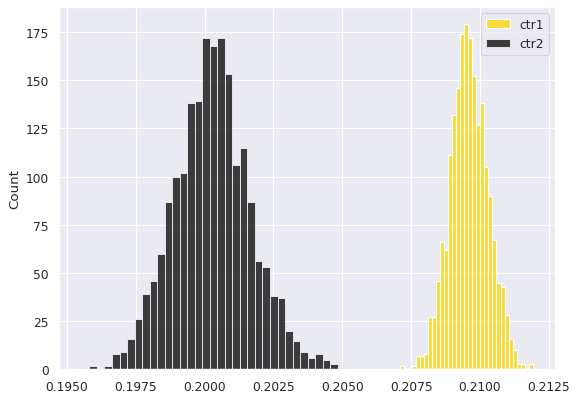

In [68]:
sns.histplot(ctr1, color = 'gold')
sns.histplot(ctr2, color = 'black')
plt.legend(['ctr1', 'ctr2'])

## По визуализации можно сделать вывод, что в 1ой группе CTR значительно выше, чем во 2ой

In [32]:
 stats.mannwhitneyu(ctr1, ctr2, alternative = 'two-sided')

MannwhitneyuResult(statistic=4000000.0, pvalue=0.0)

## Тест Манна-Уитни однозначно говорит о различиях в группах

## Визуализирую распределение разницы глобальных CTR в группах

<Axes: ylabel='Count'>

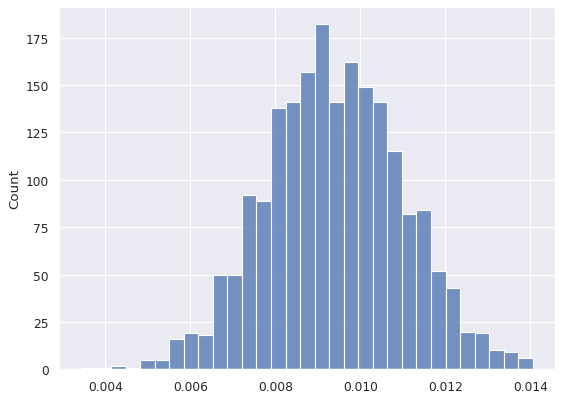

In [33]:
sns.histplot(ctr1 - ctr2)

## Распределение разницы глобальных CTR не пересекает 0 и находится правее него, что говорит о том, что CTR в 1 группе больше, чем во 2.

## Бакетное преобразование

In [34]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-12-29' and '2024-01-04'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = ph.read_clickhouse(q, connection=connection)

## Посмотрим на распределения побакетных CTR

<Axes: xlabel='bucket_ctr', ylabel='Count'>

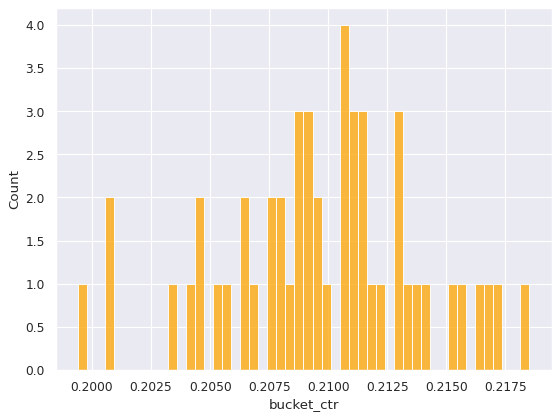

In [37]:
sns.histplot(df[df.exp_group == 1].bucket_ctr, color='orange', bins=50)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

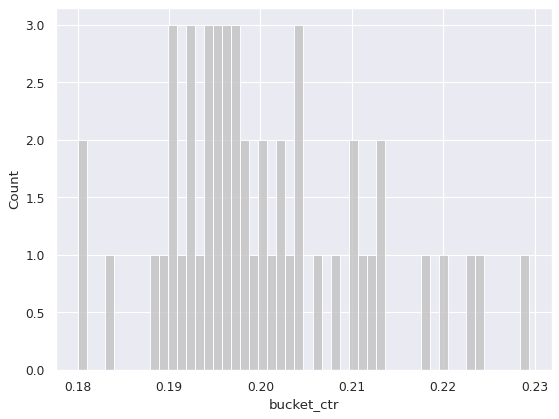

In [38]:
sns.histplot(df[df.exp_group == 2].bucket_ctr, color='silver', bins=50)

Распределения не очень похожи на нормальные, поэтому лучше использовать тест Манна-Уитни

In [43]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
                   df[df.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

## Тест Манна-Уитни показывает отличие в группах.
Проведем на всякий случай t-test

In [44]:
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
          df[df.exp_group == 2].bucket_ctr, 
          equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

## t-test также показывает отличия

## Посмотрим на распределения CTR 90ого квантиля

<Axes: xlabel='ctr9', ylabel='Count'>

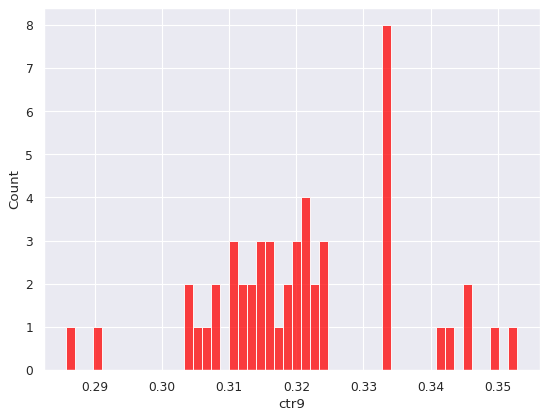

In [41]:
sns.histplot(df[df.exp_group == 1].ctr9, color='red', bins=50)

<Axes: xlabel='ctr9', ylabel='Count'>

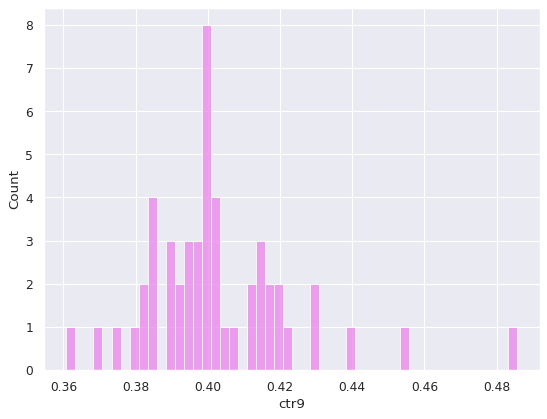

In [47]:
sns.histplot(df[df.exp_group == 2].ctr9, color='violet', bins=50)

Распределения 90ого квантиля больше напоминают нормальное распределение 

In [48]:
##Тест Манна-Уитни

stats.mannwhitneyu(df[df.exp_group == 1].ctr9,
                   df[df.exp_group == 2].ctr9,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=6.7601631082665925e-18)

In [49]:
## t-test

stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
          df[df.exp_group == 2].bucket_ctr, 
          equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

## Оба теста показывают различия

## Вывод: 

Я проанализировал результаты эксперимента по влиянию нового алгоритма рекомендации постов на метрику CTR в период с 29 декабря 2023 года по 4 января 2024 года. В 1ой группе применялся старый алгоритм, то есть она была контрольной, 2 группа - тестовая, в ней применялся новый алгоритм. Я визуализировал распределение данных на гистограмме, провел t-test и тест Манна-Уитни, где были получены противоречивые результаты, провел t-test и тест Манна-Уитни на сглаженном CTR, где также по результату t-теста нельзя было отклонить нулевую гипотезу, хотя p-value был значительно меньше, применил Пуассоновский бутстреп, чтобы посчитать разницу в глобальных CTR, который показал, что в 1 группе глобальный CTR значительно выше, а также провел бакетное преобразование, по результатам которого t-test и тест Манна-Уитни показали различия в группах. Основной вывод такой, что не следует применять новый алгоритм рекомендации постов, так как результаты в первой группе были лучше. Новый алгоритм предполагал, что будет рекомендовать посты пользователям похожие на те, которые они уже лайкали и что это может привести к увеличению метрики CTR. Но на деле, возможно, имел место обратный эффект, что пользователям было неинтересно смотреть на то, что они уже видели, поэтому новый алгоритм мог не сработать.